In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# install tweet-preprocessor to clean tweets
# source: https://towardsdatascience.com/twitter-sentiment-analysis-nlp-text-analytics-b7b296d71fce
!pip install tweet-preprocessor

import re
import preprocessor as p

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

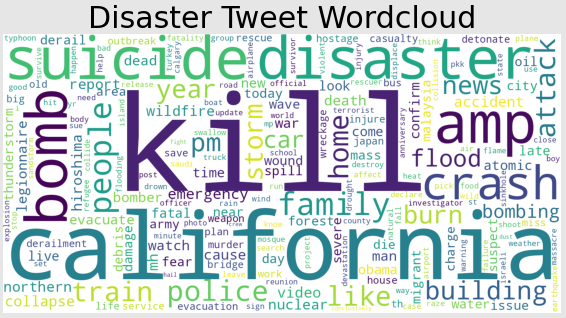
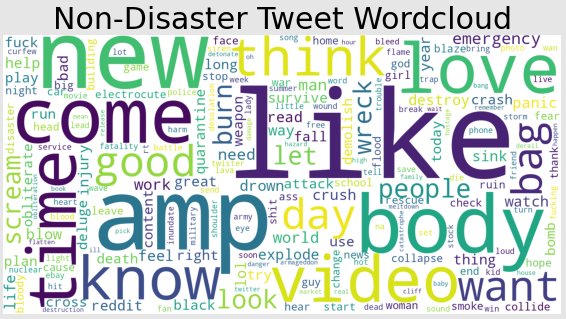

### Dataset description and machine learning problem

This dataset contains Tweeter text data for training machine learning model to predict whether the Tweets are about real disasters or not.

I will explore text representations using **bag of words**, **TF-IDF**, **Word2Vec (self-trained, pretrained)**, and **BERT (pretrained DistillBERT and BERT-based)** to create embeddings to see how will they perform with sklearn's traditional machine learning models  with their default parameters.

## 1. Read CSV files with Pandas

In [ ]:
# read the test and train datasets using Pandas
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [ ]:
# my personal reusable function for detecting missing data
def missing_value_describe(data):
    # check missing values in the data
    missing_value_stats = (data.isnull().sum() / len(data)*100)
    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]
    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        # print out column names with missing value percentage
        print("\nMissing percentage (desceding):")
        print(missing_value_stats)
    else:
        print("No missing data!!!")

#### Check missing data

In [ ]:
train.info()
missing_value_describe(train)

#### From the above result, we can observe that there are 33.27% of the data missing for the location column and there are 0.08% of the data missing for the keyword column.

In [ ]:
test.info()
missing_value_describe(test)

#### From the above result, we can observe that there are 33.86% of the data missing for the location column and there are 0.0797% of the data missing for the keyword column. Since we are interested in creating text representations using only the tweet texts, we can drop the two columns together with the id column for both the train and test datasets.

## 2. Data Preprocessing

In [ ]:
# NLP related packages
import string
import spacy
from nltk import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
!python -m spacy download en_core_web_sm

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
# drop id, keyword, and location columns for train and test datasets
cols_to_drop = ["id", "keyword", "location"]
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
train.head()

#### After dropping the aforementioned columns, we only have the "text" and "target" columns left for further text preprocessing. 
#### Now, let's apply the following preprocessing steps:
1. Lowercase the text: `.lower()`
2. Replace extra whitespaces: `.replace('\s\s+', ' ')`
3. Remove punctuations: `.translate(str.maketrans('', '', string.punctuation))`
4. Handle other Tweet related hashtags and emojis": `tweet-preprocessor.clean()`
5. lemmatization: translate a given word to its dictionary form using `token.lemma_` from spaCy
6. Remove stopwords: `gensim.parsing.preprocessing.remove_stopwords()`

In [ ]:
def remove_link(text):
    return re.compile(r'https?://\S+|www\.\S+').sub(r'',text)

def tweet_processing(text):
    # see above markdown cell for explanation
    sentence = p.clean(remove_link(text)).\
               strip().lower().translate(str.maketrans('', '', string.punctuation))
    
    # parse sentence with spacy lemmatization and remove stopwords
    doc = remove_stopwords(" ".join([token.lemma_ for token in nlp(sentence)]))
    
    # remove single letter number or letter
    doc = " ".join([word for word in doc.split() if len(word)>1])
    
    # remove -PRON- from spacy output
    return " ".join([word for word in doc.split() if word != "-PRON-"])

#### Apply the preprocessing function to the training and testing texts

In [ ]:
train["text_processed"] = train.text.apply(tweet_processing)
test["text_processed"] = test.text.apply(tweet_processing)

#### This is what the training data look like after the preprocessing

In [ ]:
train

#### This is what the testing data look like after the preprocessing

In [ ]:
test

#### After some data exploration, I notice there are duplicates in the training dataset. Let me drop the duplicates and also handle the rows with UTC timestamp in it.

In [ ]:
def helper(text):
    if "UTC]?" in text:
        return text
print("training data containing timestamp")
print(train.text.apply(helper).value_counts())

print("\ntesting data containing timestamp")
print(test.text.apply(helper).value_counts())

In [ ]:
train.query("text == 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'")

In [ ]:
train.query("text == 'M1.57 [01:11 UTC]?3km NNW of Lake Henshaw California. http://t.co/f9KQksoSw3'")

#### Let's drop row 7610 since it's a duplication of the row 7140; and remove the timestamp for row 3053 and 7140.

In [ ]:
train = train.drop(7610).reset_index(drop=True) # drop 7610 and reset index

In [ ]:
# "utc" and "km" might be important features; I manually added it back
train.iloc[3053, 2] = "utc km " + train.iloc[3053, 2].split("utc3 ")[1] 
train.iloc[7140, 2] = "utc km " + train.iloc[7140, 2].split("utc5 ")[1]

#### Now, let's create text representations with the preprocessed text data

## 3. Create Text Representations

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

### 3.1 Bag of Words

Bag of words representation of the sentence is the most straightforward one. All the unique words' word counts are recorded as features. For each sentence, the embedding is a list of numbers represented how many times the feature words appeared in the sentence. For example, let's say the entire text dataset has 6 unique words as features of ["A", "B", "C" ,"D", "E", "F"] and the 1st sentence has 3 words matched with the first 3 words in the word features with count of 1 for each word. Then, the bag of words embedding for the 1st sentence would be represented as [1, 1, 1, 0, 0, 0]. Below is a better visual example of bag of words:
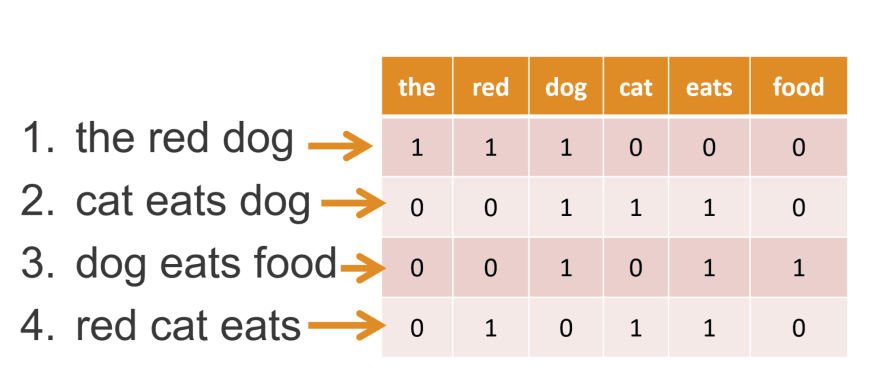

In [ ]:
# preprocessor to remove digits in string
def remove_numeric_string(text):
    return re.sub(r'\d+', '', text)

# create bag of word representation of the text data
bow_vectorizer = CountVectorizer(dtype=np.float32,
                                 preprocessor=remove_numeric_string, # remove numeric term
                                 strip_accents='unicode',
                                 tokenizer=word_tokenize,
                                 ngram_range=(1,1), # keep the unigram
                                 analyzer='word', # feature should be made of word n-gram
                                 min_df=10, # ignore terms appeared less than 10 times
                                 max_df=0.75) # ignore terms appeared more than 75% of the tweets available
bow_vector = bow_vectorizer.fit_transform(train['text_processed'])
bow_features = pd.DataFrame(bow_vector.toarray(), 
             columns=sorted(bow_vectorizer.vocabulary_))
bow_features

#### After creating bag of words representation of the text data, we obtained 1120 word features that can be used for training classification models.

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# create index arrays for filtering rows based on the target
disaster_text_row_index = train.query("target == 1").index
non_disaster_text_row_index = train.query("target == 0").index

In [ ]:
# create a dictionary of term frequency
def create_term_frequency_count(term_features):
    word_count = term_features.sum()
    return dict(zip(word_count.index, word_count.values))

# function for create wordcloud from term frequency dictionary
def create_word_cloud(category_count, title=""):
    wordcloud = WordCloud(background_color="white",
                          random_state=1, # reproducible wordcloud
                          width=1600, 
                          height=800).generate_from_frequencies(category_count)
    plt.figure(figsize=(10,10));
    plt.imshow(wordcloud)
    plt.title(label=title, fontdict={"fontsize": 30})
    plt.axis("off")
    plt.show();

In [ ]:
# create term frequency dictionary and use it for plotting the word cloud
category_count = create_term_frequency_count(bow_features.iloc[disaster_text_row_index])
create_word_cloud(category_count, title="Disaster Tweet Wordcloud")


category_count = create_term_frequency_count(bow_features.iloc[non_disaster_text_row_index])
create_word_cloud(category_count, title="Non-Disaster Tweet Wordcloud")

#### From the above two wordcloud generated by counting the term frequencies in two classes of text, we can see the disaster tweets have high frequency terms like "kill", "suicide", "bomb", and etc. And the non-disaster tweets have high frequency terms like "like", "love", "video", and etc.



#### Find best ML models available based on the data we have

#### Split the train dataset set to 80% train and 20% valid and prepare X and y data

In [ ]:
# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier 
from lightgbm.sklearn import LGBMClassifier

# classifiers / models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)

# other
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import f1_score, make_scorer, recall_score

In [ ]:
# 80-20 train valid split; only run it once
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=2021)
X_train, y_train = train_df["text_processed"], train_df["target"]
X_valid, y_valid = valid_df["text_processed"], valid_df["target"]

In [ ]:
# define preprocessor
text_features = "text_preprocessed"
target_column = 'target'

# function for storing the validation metric scores
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, 
                            return_train_score=True, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [ ]:
results_df = {}
results_df["DummyClassifier"] = mean_std_cross_val_scores(DummyClassifier(strategy="stratified", 
                                                                          random_state=2), 
                                                          X_train, y_train)
pd.DataFrame(results_df).T

#### Using dummy classifer as the baseline, we can see the baseline validation score is 0.510.
#### To make the whole cross validating process reproducible, I will set the random state and put the models into a function and only allow me to pass the embedding function to create embedding.

In [ ]:
# function to cross validate commonly used models with only change to the embedding function
def cross_validate_models(embedding_function, X_train, y_train):
    pipe_lr = make_pipeline(embedding_function, LogisticRegression(max_iter=1000, random_state=2))
    pipe_svc = make_pipeline(embedding_function, SVC(random_state=2))
    pipe_knn = make_pipeline(embedding_function, KNeighborsClassifier())
    pipe_rf = make_pipeline(embedding_function, RandomForestClassifier(random_state=2))
    pipe_lgbm = make_pipeline(embedding_function, LGBMClassifier(random_state=2))
    classifiers = {
        'Logistic Regression' : pipe_lr,
        "SVC": pipe_svc,
        'KNN' : pipe_knn,
        'Raindom Forest' : pipe_rf,
        'LightGBM' : pipe_lgbm,
    }

    # cross validation score of the default model hyperparameter
    results_df = {}
    for (name, pipe) in classifiers.items():
        print("cross validating", name)
        results_df[name] = mean_std_cross_val_scores(pipe, X_train, y_train)
    return pd.DataFrame(results_df)

# sort the model results colmuns by the validation score row with descending order
def display_model_results(model_results):
    return model_results.sort_values(by="test_score", ascending=False, axis=1)

In [ ]:
# cross validate and check the bag of words embedding performance
bow_results = cross_validate_models(bow_vectorizer, X_train, y_train)
display_model_results(bow_results) # results are sorted by test_score row for each column

#### Since this notebook is about comparing the text representations with the default model parameters, I will not tune the model or apply any feature selection or ensemble methods on the data and models. From the above output, we can observe that SVC (0.786), Logistic Regression (0.781), and LightGBM (0.765) are the top performing mode for the Bag of Word representation. Logistic regression has the smallest train and valid score gap and SVC has the second longest fit time followed after random forest.

### 3.2 TF-IDF

> TF-IDF stands for "Term Frequency — Inverse Document Frequency". It is a statistical technique that quantifies the importance of a word in a document based on how often it appears in that document and a given collection of documents (corpus).

* **TF quantifies the word frequency**: if a word occurs frequently in a document, then it should be more important and relevant than other words that appear fewer times and we should give that word a high score (TF).
* **IDF penalize the document frequency**: if a word appears many times in a document but also in too many other documents, it’s probably not a relevant and meaningful word. Hence, we should assign a lower score to that word (IDF). The number of documents is fixed. Having higher number of documents containing a term will lower its IDF whereas having a lower number of documents containing a term will increase the value of IDF. 

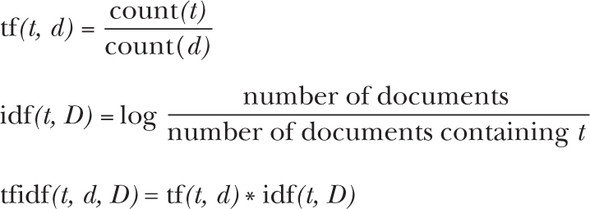

In [ ]:
# create TF-IDF representation of the text data
tfidf_vectorizer = TfidfVectorizer(dtype=np.float32,
                                   preprocessor=remove_numeric_string, # remove numeric term
                                   strip_accents='unicode',
                                   tokenizer=word_tokenize,
                                   ngram_range=(1,1), # keep the unigram
                                   analyzer='word', # feature should be made of word n-gram
                                   min_df=10, # ignore terms appeared less than 10 times
                                   max_df=0.75, # ignore terms appeared more than 75% of the tweets available
                                   sublinear_tf=True) 
tfidf_vector = tfidf_vectorizer.fit_transform(train['text_processed'])
tfidf_features = pd.DataFrame(tfidf_vector.toarray(), 
             columns=sorted(tfidf_vectorizer.vocabulary_))
tfidf_features

#### Let's visualize the TF-IDF representation with wordcloud for both the disaster texts and the non disaster texts.

In [ ]:
# create term frequency dictionary and use it for plotting the word cloud
category_count = create_term_frequency_count(tfidf_features.iloc[disaster_text_row_index])
create_word_cloud(category_count, title="Disaster Tweet Wordcloud")

category_count = create_term_frequency_count(tfidf_features.iloc[non_disaster_text_row_index])
create_word_cloud(category_count, title="Non-Disaster Tweet Wordcloud")

#### The output of the TF-IDF vectorizer looks pretty similar for the wordcloud visualization, but "scream" doesn't have high vector value in the Bag of Word representation.

In [ ]:
# baseline model
results_df = {}
results_df["DummyClassifier"] = mean_std_cross_val_scores(DummyClassifier(strategy="stratified", 
                                                                          random_state=2), 
                                                          X_train, y_train)
pd.DataFrame(results_df).T

In [ ]:
# cross validate and check the TF-IDF embedding performance
tfidf_results = cross_validate_models(tfidf_vectorizer, X_train, y_train)
display_model_results(tfidf_results) # results are sorted by test_score row for each column

#### Comparing the TF-IDF results with the Bag of Words results with the default parameters for models and minimal setups for the vectorizers, you can see the Bag of Words representation's best model SVC has slight higher validation score (0.786) than the best model of the TF-IDF representation validation score of SVC model (0.782). 

### 3.3 Word2Vec

> Word2Vec uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. As the name implies, word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.


I used the Gensim's Word2Vec model to train my own Word2Vec model and also the pretrained Google News Word2Vec model to compare the results.

For Gensim Word2Vec documantion, see here: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
import gensim
from gensim.models import Word2Vec
from collections import defaultdict

#### Since Word2Vec models will only return word embedding, I will create sentence embedding by averaging the existing words' embedding for each sentence. The below two classes will act as the function to transform the word embeddings to sentence embedding for training models.

In [ ]:
# source for creating sentence embedding from mean Word2Vec words embedding 
# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
# I made changes to the sklearn transformer to code to adapt the problem
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = next(iter(word2vec.items()))[1].shape[0]

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ], dtype=object)

In [ ]:
# create word embedding using Word2vec model and output the embedding size 
word2vec_model = Word2Vec(X_train.apply(word_tokenize), seed=1)
word2vec_dict = dict(zip(word2vec_model.wv.key_to_index.keys(), 
         word2vec_model.wv.vectors))
print(word2vec_model)

In [ ]:
# cross validate and check the self-trained Word2Vec embedding performance
word2vec_results = cross_validate_models(MeanEmbeddingVectorizer(word2vec_dict), 
                                         X_train.apply(word_tokenize), y_train)
display_model_results(word2vec_results) # results are sorted by test_score row for each column

#### Without using pretrained Word2Vec model, I trainde my own Word2Vec models using default parameters to create sentence embedding for the tweets. The performance is not as good as the Bag of Words and the TF-IDF representation. Next, I will load the Google Word2Vec pretrained word embedding to create sentence embdedding to compare the modeling results with default model parameters. 

In [ ]:
# loading pretrained google news word2vec embedding 300D
from gensim.models import KeyedVectors
word2vec_pretrained = KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin",binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(), 
                                    word2vec_pretrained.vectors))

In [ ]:
# use mean word embedding approach with pretrained Google news Word2Vec embedding
pretrained_word2vec_results = cross_validate_models(MeanEmbeddingVectorizer(word2vec_pretrained_dict), 
                                         X_train.apply(word_tokenize), y_train)
display_model_results(pretrained_word2vec_results) # results are sorted by test_score row for each column

In [ ]:
# free RAM for about 4 GB
del word2vec_pretrained
del word2vec_pretrained_dict

#### Compare the self-trained Word2Vec results vs the pretrained Google Word2Vec embedding results, the pretrained embedding achieve better results with the best model of SVC having mean validation score of 0.804, which is higher than the best bag of words model (0.786), the best TF-IDF model (0.782), and the self-trained Word2Vec model (0.684).

### 3.4 BERT

BERT was originally pre-trained on the whole of the English Wikipedia and Brown Corpus and is fine-tuned on downstream natural language processing tasks like question and answering sentence pairs.

I will use the HuggineFace pretrained DistillBERT and BERT models to create embeddings:
https://huggingface.co/bert-base-uncased

In [ ]:
import torch
import transformers

In [ ]:
# For DistilBERT:
bert_model_class, bert_tokenizer_class, bert_pretrained_weights = (transformers.DistilBertModel, 
                                                                   transformers.DistilBertTokenizer, 
                                                                   'distilbert-base-uncased')
# Load pretrained model/tokenizer
bert_tokenizer = bert_tokenizer_class.from_pretrained(bert_pretrained_weights)
bert_model = bert_model_class.from_pretrained(bert_pretrained_weights)

# use BERT tokenizer to preprocessing the sentence texts
tokenized_sentences = X_train.apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))

# pad the sentence for creating embedding
max_len = 0
for i in tokenized_sentences.values:
    if len(i) > max_len:
        max_len = len(i)

padded_sentences = np.array([i + [0]*(max_len-len(i)) for i in tokenized_sentences.values])
padded_sentences.shape

In [ ]:
# create attention mask to tell BERT to ignore the padding added when it's processing its input
attention_mask = np.where(padded_sentences != 0, 1, 0)
attention_mask.shape

In [ ]:
# this will take a while and watch out for you memory usage
input_ids = torch.tensor(padded_sentences)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = bert_model(input_ids, attention_mask=attention_mask)
bert_features = last_hidden_states[0][:,0,:].numpy()
bert_features.shape

#### After running the DistillBERT model, we obtained 768 feature columns for training ML models

In [ ]:
# use distillBERT embedding to cross validate the data
distill_bert_results = cross_validate_models(None, bert_features, y_train)
display_model_results(distill_bert_results) # results are sorted by test_score row for each column

#### Using a smaller version of BERT (DistillBERT), the best model is Logistic regression with validation score of 0.799 using default parameters, which is slightly lower than the pretrained Google News Word2Vec embedding, but better than the bag of words, TF-IDF and self-trained Word2Vec model.

In [ ]:
# For BERT
bert_model_class, bert_tokenizer_class, bert_pretrained_weights = (transformers.BertModel, 
                                                                   transformers.BertTokenizer, 
                                                                   'bert-base-uncased')
# Load pretrained model/tokenizer
bert_tokenizer = bert_tokenizer_class.from_pretrained(bert_pretrained_weights)
bert_model = bert_model_class.from_pretrained(bert_pretrained_weights)

# use BERT tokenizer to preprocessing the sentence texts
tokenized_sentences = X_train.apply((lambda x: bert_tokenizer.encode(x, add_special_tokens=True)))

# pad the sentence for creating embedding
max_len = 0
for i in tokenized_sentences.values:
    if len(i) > max_len:
        max_len = len(i)

padded_sentences = np.array([i + [0]*(max_len-len(i)) for i in tokenized_sentences.values])
padded_sentences.shape

In [ ]:
# create attention mask to tell BERT to ignore the padding added when it's processing its input
attention_mask = np.where(padded_sentences != 0, 1, 0)
attention_mask.shape

In [ ]:
# this will take a while and watch out for you memory usage
input_ids = torch.tensor(padded_sentences)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = bert_model(input_ids, attention_mask=attention_mask)
bert_features = last_hidden_states[0][:,0,:].numpy()
bert_features.shape

In [ ]:
# use BERT-based embedding to cross validate the data
bert_results = cross_validate_models(None, bert_features, y_train)
display_model_results(bert_results) # results are sorted by test_score row for each column

#### The default pretrained BERT-based model performs slightly worse than the DistillBERT model using sklearn model's default parameters. Currently, the best performing model is the SVC model trained on the Google News pretrained Word2Vec embedding with 300 dimensions with cross validation valid score of 0.804.

## 4. Evaluate best model on validation set

In [ ]:
# load the pretrained Word2Vec model again since it's deleted for saving memory
word2vec_pretrained = KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin",binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(), 
                                    word2vec_pretrained.vectors))

In [ ]:
# current best model is SVC created using the Google News pretrained Word2Vec embedding
best_model = make_pipeline(MeanEmbeddingVectorizer(word2vec_pretrained_dict), SVC(random_state=2))
best_model.fit(X_train.apply(word_tokenize), y_train)

# show classification report
print(classification_report(y_valid, best_model.predict(X_valid.apply(word_tokenize)), digits=3))

# plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(best_model, X_valid.apply(word_tokenize), y_valid,
                      values_format="d", cmap=plt.cm.Blues, ax=ax);

In [ ]:
# free RAM for about 4 GB
del word2vec_pretrained
del word2vec_pretrained_dict

#### After using the best model with default parameter with the pretrained Google News Word2Vec embedding, the validation score for the disaster tweet classification task is 0.775, which is pretty close to the cross validation score of 0.804. The model generalize well. Looking at the confusion matrix, we can observe there are larger proportion of the class 1 being predicted as class 0. More hyperparameter tuning, feature selection, and other techniques can be applied improve the modeling outcome. 

#### Since this post is about comparing the embedding performances on sklearn model with default parameters, this is the end of this kernel. 

#### If you like the notebook, please comment and upvote!